# Train  a new classifier for CoastSat

In this notebook the CoastSat classifier is trained using satellite images from new sites. This can improve the accuracy of the shoreline detection if the users are experiencing issues with the default classifier.

#### Initial settings

In [1]:
import ee
import os
# update the proxy settings
# os.environ['HTTP_PROXY'] = 'my_proxy_id:proxy_port'
# os.environ['HTTPS_PROXY'] = 'my_proxy_id:proxy_port'
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:12333'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:12333'

# Initialize the Earth Engine object, using the authentication credentials.
ee.Initialize()

In [2]:
# load modules
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import sklearn
if sklearn.__version__[:4] == '0.20':
    from sklearn.externals import joblib
else:
    import joblib

# coastsat modules
sys.path.insert(0, os.pardir)
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_classify

# plotting params
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12

# filepaths 
filepath_images = os.path.join(os.getcwd(), 'data')
filepath_train = os.path.join(os.getcwd(), 'training_data')
filepath_models = os.path.join(os.getcwd(), 'models')

# settings
settings ={'filepath_train':filepath_train, # folder where the labelled images will be stored
           'cloud_thresh':0.9, # percentage of cloudy pixels accepted on the image
           'cloud_mask_issue':True, # set to True if problems with the default cloud mask 
           'inputs':{'filepath':filepath_images}, # folder where the images are stored
           'labels':{'sand':1,'white-water':2,'water':3,'other land features':4}, # labels for the classifier
           'colors':{'sand':[1, 0.65, 0],'white-water':[1,0,1],'water':[0.1,0.1,0.7],'other land features':[0.8,0.8,0.1]},
           'tolerance':0.01, # this is the pixel intensity tolerance, when using flood fill for sandy pixels
                             # set to 0 to select one pixel at a time
            }
        
# read kml files for the training sites
filepath_sites = os.path.join(os.getcwd(), 'training_sites')
train_sites = os.listdir(filepath_sites)
print('Sites for training:\n%s\n'%train_sites)

Sites for training:
['NEWCASTLE.kml', 'BYRON.kml', 'SAWTELL.kml']



### 1. Download images

For each site on which you want to train the classifier, save a .kml file with the region of interest (5 vertices clockwise, first and last points are the same, can be created from Google myMaps) in the folder *\training_sites*.

You only need a few images (~10) to train the classifier.

In [3]:
# dowload images at the sites
dates = ['2019-01-01', '2019-07-01']
sat_list = ['L8']
for site in train_sites:
    polygon = SDS_tools.polygon_from_kml(os.path.join(filepath_sites,site))
    polygon = SDS_tools.smallest_rectangle(polygon)
    sitename = site[:site.find('.')]  
    inputs = {'polygon':polygon, 'dates':dates, 'sat_list':sat_list,
             'sitename':sitename, 'filepath':filepath_images}
    print(sitename)
#     metadata = SDS_download.retrieve_images(inputs)
    # I have download the 
    metadata = SDS_download.get_metadata(inputs) 

NEWCASTLE
BYRON
SAWTELL


### 2. Label images

Label the images into 4 classes: sand, white-water, water and other land features.

The labelled images are saved in the *filepath_train* and can be visualised afterwards for quality control. If yo make a mistake, don't worry, this can be fixed later by deleting the labelled image.

In [39]:
a = dict([])
a

{}

In [ ]:
# label the images with an interactive annotator
%matplotlib qt
for site in train_sites:
    settings['inputs']['sitename'] = site[:site.find('.')] 
    # load metadata
    metadata = SDS_download.get_metadata(settings['inputs'])
    # label images
    SDS_classify.label_images(metadata,settings)

### 3. Train Classifier

A Multilayer Perceptron is trained with *scikit-learn*. To train the classifier, the training data needs to be loaded.

You can use the data that was labelled here and/or the original CoastSat training data.

In [ ]:
# load labelled images
features = SDS_classify.load_labels(train_sites, settings)

In [10]:
#-------------------
with open(os.path.join(settings['filepath_train'], './NEWCASTLE/2019-03-11-23-43-20_L8_NEWCASTLE.pkl'), 'rb') as f:
    features_test = pickle.load(f)

In [32]:
features_test['features']['sand'][0]

array([ 0.2 ,  0.25,  0.29,  0.39,  0.41,  0.22,  0.25,  0.14,  0.03,
       -0.19,  0.02,  0.04,  0.06,  0.04,  0.05,  0.05,  0.04,  0.07,
        0.02,  0.06])

In [25]:
152*170

25840

In [20]:
features_test['features']['sand'].shape
res=0
for key in features_test['features'].keys():
    print('%s : %d,%d pixels'%(key,*features_test['features'][key].shape))
    res+=len(features_test['features'][key])
    
res

sand : 79,20 pixels
white-water : 29,20 pixels
water : 6382,20 pixels
other land features : 11820,20 pixels


18310

In [98]:
# you can also load the original CoastSat training data (and optionally merge it with your labelled data)
with open(os.path.join(settings['filepath_train'], 'CoastSat_training_set_L8.pkl'), 'rb') as f:
    features_original = pickle.load(f)
for key in features_original.keys():
    print('%s : %d pixels'%(key,len(features_original[key])))

sand : 7009 pixels
water : 18513 pixels
white-water : 752 pixels
other land features : 29399 pixels


Run this section to combine the original training data with your labelled data:

In [93]:
# add the white-water data from the original training data
features['white-water'] = np.append(features['white-water'], features_original['white-water'], axis=0)
# or merge all the classes
# for key in features.keys():
#     features[key] = np.append(features[key], features_original[key], axis=0)
#features = features_original 
for key in features.keys():
    print('%s : %d pixels'%(key,len(features[key])))

sand : 7009 pixels
water : 500 pixels
white-water : 1504 pixels
other land features : 500 pixels


In [99]:
# tino: run this when you only use the given training data
features = features_original

[OPTIONAL] As the classes do not have the same number of pixels, it is good practice to subsample the very large classes (in this case 'water' and 'other land features'):

In [100]:
# subsample randomly the land and water classes
# as the most important class is 'sand', the number of samples should be close to the number of sand pixels
n_samples = 5000
for key in ['water', 'other land features']:
    features[key] =  features[key][np.random.choice(features[key].shape[0], n_samples, replace=False),:]
# print classes again
for key in features.keys():
    print('%s : %d pixels'%(key,len(features[key])))

sand : 7009 pixels
water : 5000 pixels
white-water : 752 pixels
other land features : 5000 pixels


When the labelled data is ready, format it into X, a matrix of features, and y, a vector of labels:

In [101]:
# format into X (features) and y (labels) 
classes = ['sand','white-water','water','other land features']
labels = [1,2,3,0]
X,y = SDS_classify.format_training_data(features, classes, labels)

In [102]:
X.shape

(17761, 20)

Divide the dataset into train and test: train on 70% of the data and evaluate on the other 30%:

In [42]:
X_train.shape

(12432, 20)

In [160]:
# prepare data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)

## NN Classifier

In [161]:
# divide in train and test and evaluate the classifier
classifier = MLPClassifier(hidden_layer_sizes=(100,50), solver='adam')
classifier.fit(X_train,y_train)
print('Accuracy: %0.4f' % classifier.score(X_test,y_test))
classifier.score(X_test,y_test)

Accuracy: 0.9996


0.99962469506474

[OPTIONAL] A more robust evaluation is 10-fold cross-validation (may take a few minutes to run):

Confusion matrix, without normalization


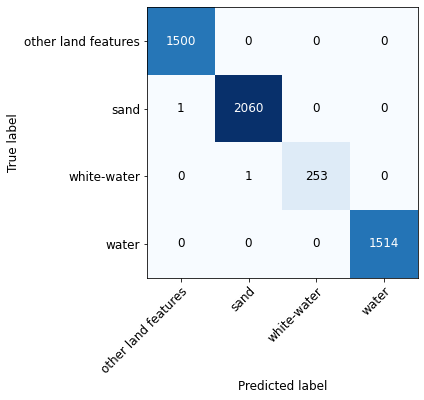

In [162]:
# plot confusion matrix
%matplotlib inline
y_pred = classifier.predict(X_test)
SDS_classify.plot_confusion_matrix(y_test, y_pred,
                                   classes=['other land features','sand','white-water','water'],
                                   normalize=False);

## RF Classifier

In [163]:
from sklearn.ensemble import RandomForestClassifier
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)
tino_rfclassifier=RandomForestClassifier(n_estimators=20)
tino_rfclassifier.fit(X_train,y_train)
print(tino_rfclassifier.score(X_test,y_test))

0.9990617376618502


Confusion matrix, without normalization


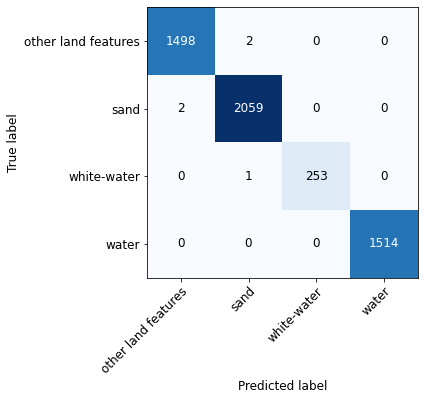

In [164]:
y_pred = tino_rfclassifier.predict(X_test)
SDS_classify.plot_confusion_matrix(y_test, y_pred,
                                   classes=['other land features','sand','white-water','water'],
                                   normalize=False);

## KNN Classifier

In [165]:
from sklearn.neighbors import KNeighborsClassifier
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)
tino_knclassifier = KNeighborsClassifier(n_neighbors=5)
tino_knclassifier.fit(X_train,y_train)
print(tino_knclassifier.score(X_test,y_test))

0.9983111277913305


Confusion matrix, without normalization


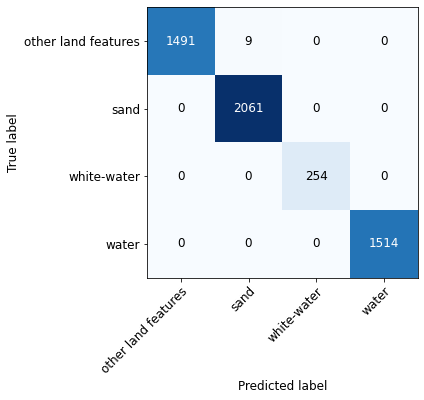

In [166]:
y_pred = tino_knclassifier.predict(X_test)
SDS_classify.plot_confusion_matrix(y_test, y_pred,
                                   classes=['other land features','sand','white-water','water'],
                                   normalize=False);

In [167]:
from sklearn import svm
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)
tino_svmclassifier = svm.SVC()
tino_svmclassifier.fit(X_train,y_train)
print(tino_svmclassifier.score(X_test,y_test))


0.9984987802589604


Confusion matrix, without normalization


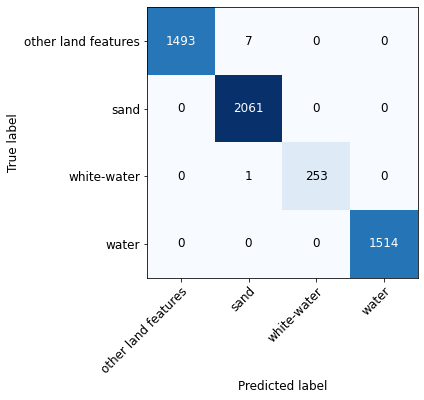

In [168]:
y_pred = tino_svmclassifier.predict(X_test)
SDS_classify.plot_confusion_matrix(y_test, y_pred,
                                   classes=['other land features','sand','white-water','water'],
                                   normalize=False);

In [169]:
from sklearn.tree import DecisionTreeClassifier
tino_cartclassifier = DecisionTreeClassifier()
tino_cartclassifier.fit(X_train,y_train)
print(tino_cartclassifier.score(X_test,y_test))

0.9973728654531807


Confusion matrix, without normalization


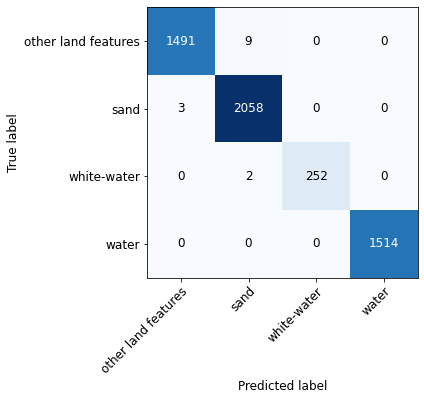

In [170]:
y_pred = tino_cartclassifier.predict(X_test)
SDS_classify.plot_confusion_matrix(y_test, y_pred,
                                   classes=['other land features','sand','white-water','water'],
                                   normalize=False);

In [78]:
# cross-validation
scores = cross_val_score(classifier, X, y, cv=10)
print('Accuracy: %0.4f (+/- %0.4f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.9993 (+/- 0.0018)


Plot a confusion matrix:

Confusion matrix, without normalization


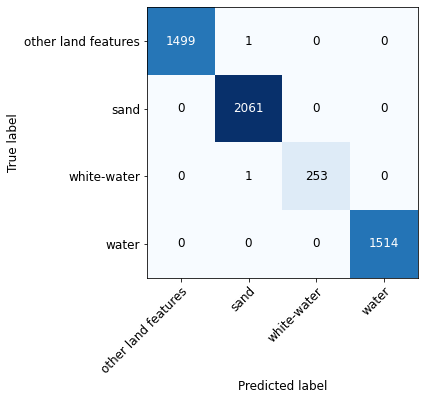

Confusion matrix, without normalization


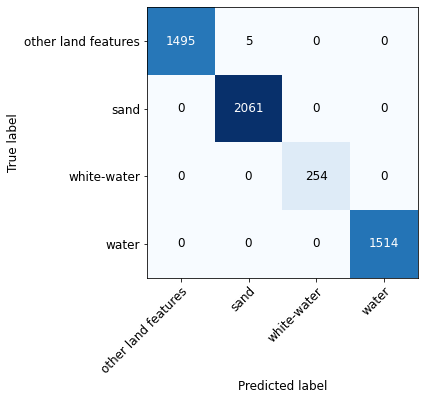

Confusion matrix, without normalization


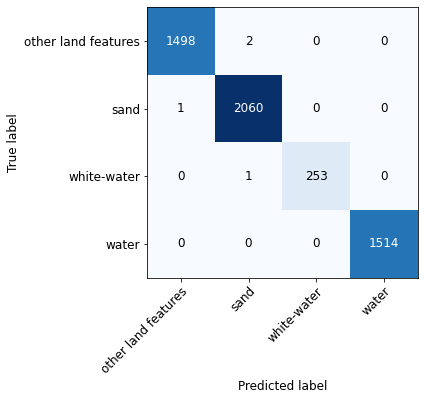

When satisfied with the accuracy and confusion matrix, train the model using ALL the training data and save it:

In [ ]:
# train with all the data and save the final classifier
classifier = MLPClassifier(hidden_layer_sizes=(100,50), solver='adam')
classifier.fit(X,y)
joblib.dump(classifier, os.path.join(filepath_models, 'NN_4classes_Landsat_test.pkl'))

### 4. Evaluate the classifier

Load a classifier that you have trained (specify the classifiers filename) and evaluate it on the satellite images.

This section will save the output of the classification for each site in a directory named \evaluation.

In [ ]:
# load and evaluate a classifier
%matplotlib qt
classifier = joblib.load(os.path.join(filepath_models, 'NN_4classes_Landsat_test.pkl'))
settings['output_epsg'] = 3857
settings['min_beach_area'] = 4500
settings['buffer_size'] = 200
settings['min_length_sl'] = 200
settings['cloud_thresh'] = 0.5
# visualise the classified images
for site in train_sites:
    settings['inputs']['sitename'] = site[:site.find('.')] 
    # load metadata
    metadata = SDS_download.get_metadata(settings['inputs'])
    # plot the classified images
    SDS_classify.evaluate_classifier(classifier,metadata,settings)